In [1]:
#import libraries

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
airlines = pd.read_csv('./data/collected_data.csv')

<a id="vader_processing"></a>
## Pre-processing for VADER

In [3]:
#remove line splitters
airlines['text'].replace(to_replace='\n', value= ' ', inplace = True, regex = True)

#remove @tags
airlines['text'].replace(to_replace=r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", value = '', inplace = True, regex = True)

#remove 'RT'
airlines['text'].replace(to_replace='RT', value= '', inplace = True, regex = True)

# remove urls
airlines['text'].replace(to_replace=r"http*.*",value='',regex=True, inplace=True)

# remove duplicates
airlines.drop_duplicates(subset ="text", keep = 'first', inplace = True)

## Using VADER

In [4]:
# defining sentiment analysis model (VADER)
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores_neg(sentence):
    score = analyser.polarity_scores(sentence)
    return score['neg']

def sentiment_analyzer_scores_pos(sentence):
    score = analyser.polarity_scores(sentence)
    return score['pos']

def sentiment_analyzer_scores_neu(sentence):
    score = analyser.polarity_scores(sentence)
    return score['neu']

def sentiment_analyzer_scores_com(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

In [5]:
airlines['negative'] = airlines['text'].apply(sentiment_analyzer_scores_neg)
airlines['positive'] = airlines['text'].apply(sentiment_analyzer_scores_pos)
airlines['neutral'] = airlines['text'].apply(sentiment_analyzer_scores_neu)
airlines['compound'] = airlines['text'].apply(sentiment_analyzer_scores_com)

In [6]:
airlines[['text','positive','neutral','negative','compound']].sort_values(by=['compound'])

,text,positive,neutral,negative,compound
706,is the worst Worst reservation policies Worst...,0.157,0.226,0.617,-0.9655
2412,Once again I am victim to the scam that is yo...,0.000,0.611,0.389,-0.9400
866,after a Cancelled Flighted flight and 2 delay...,0.000,0.472,0.528,-0.9396
4700,Just so yall know im stuck in DC I hated Unite...,0.100,0.285,0.616,-0.9382
2614,WTF Delay after delay 15 hours YVR to SAN Una...,0.000,0.491,0.509,-0.9265
4306,is the worst airlines and has the worst custo...,0.000,0.423,0.577,-0.9231
689,you are the worst airline in the world From y...,0.000,0.624,0.376,-0.9222
5774,United airlines fucking SUCK horrible horrible...,0.095,0.408,0.496,-0.9150
2720,worst airline ever Staff is nasty wifi down b...,0.000,0.623,0.377,-0.9136
4651,I used to love united airlines so much but in ...,0.117,0.519,0.364,-0.9103


In [7]:
airlines[['text','positive','neutral','negative','compound']].describe()

,positive,neutral,negative,compound
count,5954.000000,5954.000000,5954.000000,5954.000000
mean,0.146622,0.760178,0.092529,0.094691
std,0.157970,0.172802,0.121981,0.449006
min,0.000000,0.000000,0.000000,-0.965500
25%,0.000000,0.659000,0.000000,-0.250000
50%,0.124000,0.769000,0.000000,0.025800
75%,0.235000,0.877000,0.159000,0.421500
max,1.000000,1.000000,1.000000,0.971100


In [8]:
pickle.dump(airlines, open("website/static/pickle/vader-ed.pkl", "wb"))

<a id="vectorizing"></a>
## Preprocessing for vectorizing

In [9]:
#change to lower case
airlines['lemmatized'] = airlines['text'].str.lower()

# remove punctuation and urls
airlines['lemmatized'].replace(to_replace=r"[^\w\d'\s]",value='',regex=True, inplace=True)

#remove numbers
airlines['lemmatized'].replace(to_replace=r"\d+", value='',regex=True, inplace=True)

In [10]:
# tokenize the text by splitting (leaving apostrophe to be used in remove stop words)
airlines['lemmatized'] = airlines['lemmatized'].str.split()

In [11]:
#remove stop words
add = ["i'm", "i've","airlines","airline","flight","united","amp","u","im","ua","pm"]
to_remove = (stopwords.words("english")) + add
airlines['lemmatized'] = airlines['lemmatized'].apply(lambda x: [item for item in x if item not in to_remove])


In [12]:
#remove apostrophes
airlines['lemmatized'].replace(to_replace="'", value = '', inplace = True, regex = True)

In [13]:
# Stem the text

lemmatizer = WordNetLemmatizer()

def lem_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

airlines['lemmatized'] = airlines['lemmatized'].apply(lem_text)

## TextBlob

In [14]:
airlines['clean'] = airlines['lemmatized'].apply(' '.join)

def sentiment_calc_polarity(text):
    try:
        return TextBlob(text).sentiment[0]
    except:
        return None
    
def sentiment_calc_subjectivity(text):
    try:
        return TextBlob(text).sentiment[1]
    except:
        return None


airlines['blob_polarity'] = airlines['clean'].apply(sentiment_calc_polarity)
airlines['blob_subjectivity'] = airlines['clean'].apply(sentiment_calc_subjectivity)

airlines[(airlines['compound'] >= 0.45) & (airlines['compound'] <= 0.55)][['text','positive','neutral','negative','compound','blob_polarity','blob_subjectivity']]

,text,positive,neutral,negative,compound,blob_polarity,blob_subjectivity
5,Your ERIORD express connections are hugely po...,0.171,0.829,0.000,0.4754,0.600000,0.900000
14,So I can buy tix 3 days before flight but ca...,0.154,0.846,0.000,0.4767,-0.500000,0.500000
20,yes David Allan send an email with this numbe...,0.290,0.710,0.000,0.4723,0.000000,0.000000
42,Have clients with an 11 hr layover at IAH dur...,0.110,0.890,0.000,0.4939,0.000000,0.000000
81,OKC ticket agent Roger McLarrensp LESS than h...,0.240,0.650,0.110,0.4970,0.000000,0.000000
83,another fail for the United ticket agents in ...,0.278,0.543,0.179,0.5076,-0.250000,0.150000
123,Pls Help Baby Hannah get the life saving surg...,0.235,0.765,0.000,0.4588,0.000000,0.000000
133,Everyone around us is sitting with their frie...,0.134,0.866,0.000,0.4767,0.000000,0.000000
144,I wonder if sharing all this on FB and insta ...,0.194,0.806,0.000,0.4767,0.200000,0.200000
160,common keep your paper work ready and dont de...,0.309,0.691,0.000,0.5365,-0.050000,0.500000


## Spellcheck

In [15]:
#airlines['spell_checked'] = airlines['clean'].apply(lambda txt: ''.join(TextBlob(txt).correct()))

In [16]:
#airlines[['clean','spell_checked']]

<a id="word_cloud"></a>
## Ploting a Word Cloud

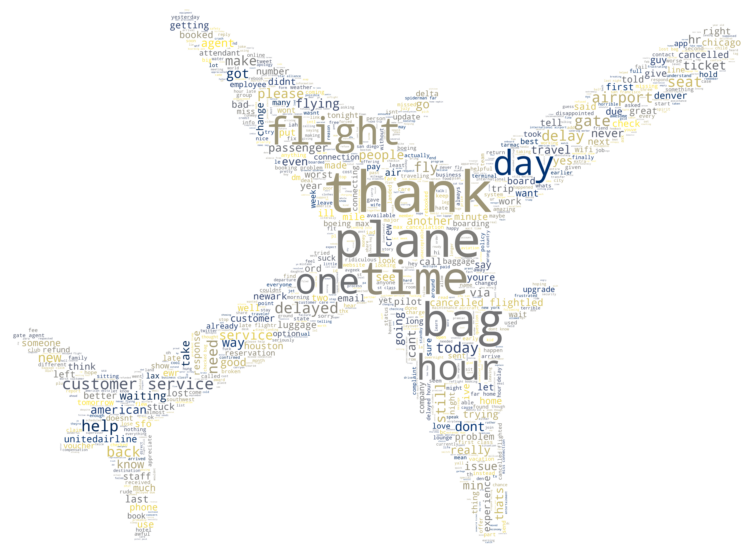

In [17]:
# Generate a word cloud image
mask = np.array(Image.open("airplane.png"))
plane_text = " ".join(review for review in airlines.clean) 
wordcloud_plane = WordCloud(background_color="white", mode="RGBA", max_words=1000, width=1600, height=800, mask=mask).generate(plane_text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,10])
plt.imshow(wordcloud_plane.recolor(colormap='cividis'), interpolation="bilinear")
plt.axis("off")
plt.savefig('website/static/images/word_cloud.png')
plt.show()

In [18]:
airlines.drop(['Unnamed: 0'],axis=1,inplace=True)

In [19]:
airlines.to_csv('./data/with_sentiment.csv')